In [1]:
import numpy as np

from flagger import BayesFlaggerBeta
from flagger_tools import BayesFlaggerBetaTest, ModelError
from flagger_tools import get_sampler_model
from matplotlib import pyplot as plt
from tmvbeta import TMVBeta

<string>:11: SyntaxWarning: invalid escape sequence '\s'
<string>:193: SyntaxWarning: invalid escape sequence '\s'


### Synthetic Data

Load model parameters

In [2]:
params = np.load("Data/parameters.npz")
a = params['a']
b = params['b']
cov = params['cov']

Create sampler from model

In [3]:
r = 0.2
P0 = TMVBeta(a[0], b[0], cov[0])
P1 = TMVBeta(a[1], b[1], cov[1])
sampler = get_sampler_model(r, P0, P1)

Administration parameters

In [4]:
K = 20   # Number of reviews per admin
M = 10   # Length of feature vector
N = 100  # Number of test takers per admin
T = 100  # Number of admins (time horizon)

Initialize flaggers with different selection policies

In [5]:
bayes_flagger_pol_1 = BayesFlaggerBeta(K, M, rule="detection")
bayes_flagger_pol_2 = BayesFlaggerBeta(K, M, rule="information")
bayes_flagger_pol_3 = BayesFlaggerBeta(K, M, rule="mixed")

Initialize testing classes

In [6]:
bayes_test_pol_1 = BayesFlaggerBetaTest(bayes_flagger_pol_1, sampler, N)
bayes_test_pol_2 = BayesFlaggerBetaTest(bayes_flagger_pol_2, sampler, N)
bayes_test_pol_3 = BayesFlaggerBetaTest(bayes_flagger_pol_3, sampler, N)

Number of simulated rollouts

In [7]:
rollouts = 20

Simulate detection-greedy policy

In [8]:
total_pol_1 = np.zeros((rollouts, T + 1))
detected_pol_1 = np.zeros((rollouts, T + 1))
model_pol_1 = []

for n in range(rollouts):
    total_pol_1[n], detected_pol_1[n], model, _ = bayes_test_pol_1.run(T)
    model_pol_1.append(model)

Simulate information-greedy policy

In [9]:
total_pol_2 = np.zeros((rollouts, T + 1))
detected_pol_2 = np.zeros((rollouts, T + 1))
model_pol_2 = []

for n in range(rollouts):
    total_pol_2[n], detected_pol_2[n], model, _ = bayes_test_pol_2.run(T)
    model_pol_2.append(model)

Simulate mixed policy

In [10]:
total_pol_3 = np.zeros((rollouts, T + 1))
detected_pol_3 = np.zeros((rollouts, T + 1))
phi_pol_3 = np.zeros((rollouts, T + 1))
model_pol_3 = []

for n in range(rollouts):
    total_pol_3[n], detected_pol_3[n], model, phi_pol_3[n] = bayes_test_pol_3.run(T)
    model_pol_3.append(model)

Plot average detection rates

In [11]:
rate_1 = np.mean(detected_pol_1[:, 1:] / total_pol_1[:, 1:], axis=0)
rate_2 = np.mean(detected_pol_2[:, 1:] / total_pol_2[:, 1:], axis=0)
rate_3 = np.mean(detected_pol_3[:, 1:] / total_pol_3[:, 1:], axis=0)

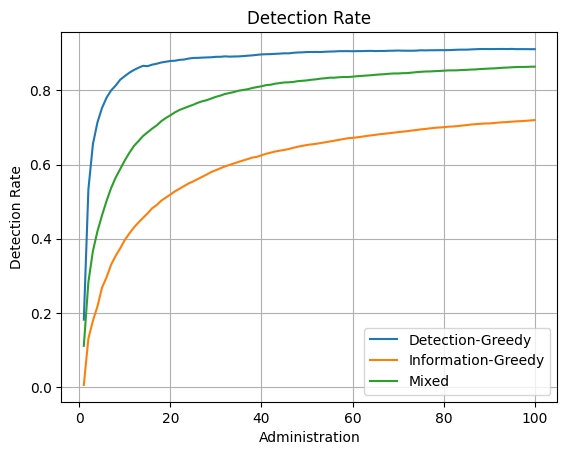

In [12]:
plt.plot(range(1, T+1), rate_1, label="Detection-Greedy")
plt.plot(range(1, T+1), rate_2, label="Information-Greedy")
plt.plot(range(1, T+1), rate_3, label="Mixed")
plt.title("Average Detection Rate")
plt.ylabel("Average Detection Rate")
plt.xlabel("Administration")
plt.legend()
plt.grid()

Plot model errors

In [13]:
model_err = ModelError(r, a, b, cov)

In [14]:
# MSE of R in dB
mse_r_pol_1 = np.zeros((20, T + 1))
mse_r_pol_2 = np.zeros((20, T + 1))
mse_r_pol_3 = np.zeros((20, T + 1))

for n in range(rollouts):
    mse_r_pol_1[n] = 10 * np.log10(np.array([model_err.mse_r(model) for model in model_pol_1[n]]))
    mse_r_pol_2[n] = 10 * np.log10(np.array([model_err.mse_r(model) for model in model_pol_2[n]]))
    mse_r_pol_3[n] = 10 * np.log10(np.array([model_err.mse_r(model) for model in model_pol_3[n]]))

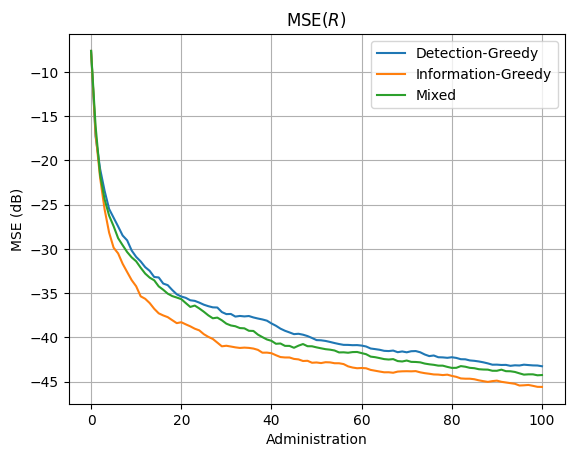

In [15]:
plt.plot(range(T+1), np.mean(mse_r_pol_1, axis=0), label="Detection-Greedy")
plt.plot(range(T+1), np.mean(mse_r_pol_2, axis=0), label="Information-Greedy")
plt.plot(range(T+1), np.mean(mse_r_pol_3, axis=0), label="Mixed")
plt.title("MSE($R$)")
plt.ylabel("MSE (dB)")
plt.xlabel("Administration")
plt.legend()
plt.grid()

In [16]:
# MSE of covariance matrix for critical group in dB
mse_cov1_pol_1 = np.zeros((20, T + 1))
mse_cov1_pol_2 = np.zeros((20, T + 1))
mse_cov1_pol_3 = np.zeros((20, T + 1))

for n in range(rollouts):
    mse_cov1_pol_1[n] = 10 * np.log10(np.array([model_err.mse_cov(1, model) for model in model_pol_1[n]]))
    mse_cov1_pol_2[n] = 10 * np.log10(np.array([model_err.mse_cov(1, model) for model in model_pol_2[n]]))
    mse_cov1_pol_3[n] = 10 * np.log10(np.array([model_err.mse_cov(1, model) for model in model_pol_3[n]]))

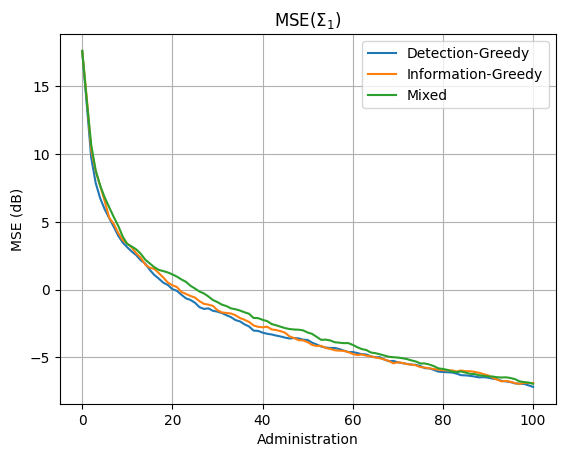

In [17]:
plt.plot(range(T+1), np.mean(mse_cov1_pol_1, axis=0), label="Detection-Greedy")
plt.plot(range(T+1), np.mean(mse_cov1_pol_2, axis=0), label="Information-Greedy")
plt.plot(range(T+1), np.mean(mse_cov1_pol_3, axis=0), label="Mixed")
plt.title(r"MSE($\Sigma_1$)")
plt.ylabel("MSE (dB)")
plt.xlabel("Administration")
plt.legend()
plt.grid()

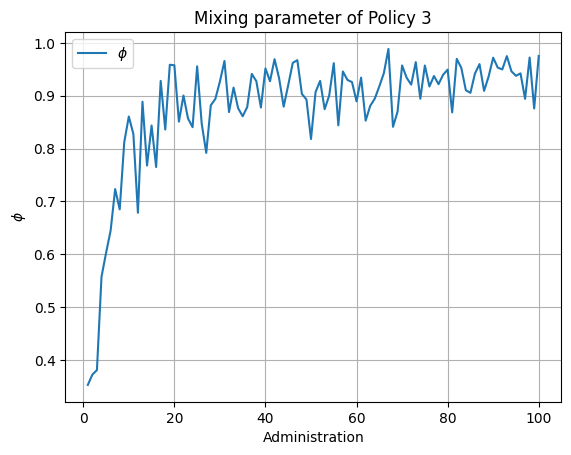

In [18]:
plt.plot(range(1, T+1), np.mean(phi_pol_3[:,1:], axis=0), label=r"$\phi$")
plt.title("Mixing parameter of Policy 3")
plt.ylabel(r"$\phi$")
plt.xlabel("Administration")
plt.legend()
plt.grid()